In [73]:
import stan
import pandas as pd
import nest_asyncio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nest_asyncio.apply()

In [74]:
schools_code = """

data {
  int<lower=0> T;   // # time points (equally spaced)
  vector[T] y;      // mean corrected return at time t
  vector[T] X;
  
  vector[T] D_sun;
  vector[T] D_sat;
  vector[T] D_mon;
}

parameters {
  real mu;
  real psi;
  real d_sat;
  real d_sun;
  real d_mon;

  vector[T] epsilon_1;
  vector[T] epsilon_2;

  real<lower=0> eta_u;
  real<lower=0> eta_d;

  real kappa_hs;
  real<lower=0> omega_h;
  real<lower=-1,upper=1> phi_h;
  real theta_h;

  // vector[3] alpha;
  array[T] simplex[3] q;

  vector[T] J_s;
  vector[T] h_s;
}
transformed parameters { 
  vector[T] J = J_s;
  vector[T] h = h_s;
  vector<lower=0>[T] xi_d;
  vector<lower=0>[T] xi_u;
  vector[T] y_fit;
  real kappa_h;

  if (kappa_hs > 2) {
    kappa_h = 0;
  }
  else if (kappa_hs < 0) {
    kappa_h = 0;
  }
  else {
    kappa_h = kappa_hs;
  }

  for (t in 1:T) {
    xi_d[t] = exp(eta_d);
    xi_u[t] = exp(eta_u);
  }

  for (t in 1:T) {
    J[t] = -xi_d[t] * q[t][1] + 0 * q[t][2] + xi_u[t] * q[t][3];
  }

  h[1] = 0;
  for (t in 2:T) {
    h[t] = h[t-1] + kappa_h * (theta_h - h[t-1]) + phi_h * epsilon_1[t] + sqrt(omega_h) * epsilon_2[t];
  }

  for (t in 2:600) {
    y_fit[t] = y[t] - y[t-1] - mu - psi * X[t] - J[t] - d_sat * D_sat[t] - d_sun * D_sun[t] - d_mon * D_mon[t];
  }
}
model {
  // Prior
  mu ~ normal(0, 10);
  psi ~ normal(0, 10);

  d_sat ~ normal(0, 10);
  d_sun ~ normal(0, 10);
  d_mon ~ normal(0, 10);

  kappa_hs ~ normal(1, 6);

  omega_h ~ inv_gamma(3, 0.05);
  phi_h ~ normal(0, 0.5 * omega_h);
  theta_h ~ normal(0, 10);

  eta_u ~ inv_gamma(1.86, 0.43);
  eta_d ~ inv_gamma(1.86, 0.43);

  //alpha = rep_vector(1, 3);
  for (t in 1:T) {
    q[t] ~ dirichlet(rep_vector(1, 3));
  }

  for (t in 1:T) {
    epsilon_1[t] ~ normal(0, 1);
    epsilon_2[t] ~ normal(0, 1);
  }

  for (t in 2:600) {
    y_fit[t] ~ normal(0, exp(h[t] / 2));
  }
}
generated quantities {  
  vector[T] y_rep = y;
  for (t in 600:T) {
    y_rep[t] = y[t-1] + mu + psi * X[t] + J[t] + d_sat * D_sat[t] + d_sun * D_sun[t] + d_mon * D_mon[t] + epsilon_1[t] * sqrt(exp(h[t-1]));
  }
}
"""

data = { 
    "T": 730,
    "y": pd.read_csv('/home/tim/dv/bsv_inference/data/hour_4.csv')['log_price'].to_numpy(),
    "X": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/df_temp4.csv', usecols=['log_temp']).to_numpy()),

    "D_sun": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/sundays.csv').to_numpy()),
    "D_sat": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/saturdays.csv').to_numpy()),
    "D_mon": np.squeeze(pd.read_csv('/home/tim/dv/bsv_inference/data/mondays.csv').to_numpy())
    }

posterior = stan.build(schools_code, data=data)
fit = posterior.sample()
df = fit.to_frame()  # pandas `DataFrame, requires pandas

Building...



Building: 12.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_e8uqh5w6/model_tfrwncwl.stan', line 84, column 25: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_e8uqh5w6/model_tfrwncwl.stan', line 48, column 7: A
    control flow statement depends on parameter(s): kappa_hs.
Warning in '/tmp/httpstan_e8uqh5w6/model_tfrwncwl.stan', line 45, column 2: A
    control flow statement depends on parameter(s): kappa_hs.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (

In [83]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,psi,d_sat,...,y_rep.721,y_rep.722,y_rep.723,y_rep.724,y_rep.725,y_rep.726,y_rep.727,y_rep.728,y_rep.729,y_rep.730
draws,,,,,,,,,,,,,,,,,,,,,
0,-1182.203032,0.936401,0.000834,9.0,762.0,1.0,3361.504121,0.014226,0.000911,0.077970,...,7.396807,8.071149,6.461134,6.725989,5.371347,6.817330,5.973647,7.855465,6.570741,7.166918
1,-1170.186394,0.716318,0.000701,10.0,1023.0,0.0,3367.252204,-0.041414,0.010910,0.081670,...,7.351453,6.955298,6.864536,8.046932,6.496318,5.943052,7.310744,8.119773,6.849669,6.853686
2,-711.459256,0.998988,0.000809,10.0,1023.0,0.0,2925.931835,0.076676,-0.024460,0.173244,...,7.310860,6.832182,7.037017,6.697162,6.312319,7.054471,7.692795,6.547857,7.272412,6.719991
3,-1278.396940,0.953661,0.002306,10.0,1023.0,0.0,3472.912607,-0.009518,0.007186,0.084419,...,7.769882,7.189156,6.263073,7.707648,7.005683,7.591857,7.102421,6.929362,6.849958,7.171208
4,-1166.219250,0.979210,0.000834,10.0,1023.0,0.0,3391.554576,0.020365,-0.000621,0.074082,...,7.455577,8.023380,6.450243,6.614663,5.505263,6.833527,6.036464,7.822287,6.645360,7.217235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-1208.083918,0.976395,0.002306,10.0,1023.0,0.0,3409.911261,-0.002824,0.000995,0.089557,...,7.168548,7.599079,6.824184,7.401356,7.340200,6.631505,6.828940,7.177246,7.082997,6.939171
3996,-1567.739831,0.993197,0.000834,10.0,1023.0,0.0,3731.049224,0.003288,-0.008732,0.077697,...,7.572988,7.272268,7.638490,6.612666,6.710693,7.354959,6.995113,7.559482,7.320401,7.335886
3997,-1350.323159,0.987488,0.000701,10.0,1023.0,0.0,3626.966521,0.182093,-0.044398,0.066743,...,7.677716,7.944036,6.461577,7.404208,7.243982,7.815084,7.229524,7.089636,7.153460,6.210763


In [84]:
# Define initial date
initial_date = '2022-01-01'
# Define number of days
num_days = 729
log_prices_arr = []
for i in range(1, 730):
    tf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['25%']
    sf = df[f'y_rep.{i}'].describe(percentiles=[0.25, 0.5, 0.75])['75%']
    no_outliers = [n for n in df[f'y_rep.{i}'].to_numpy() if (tf < n < sf)]

    log_prices_arr.append(np.median(no_outliers))

prices = np.exp(log_prices_arr)

# Create datetime range starting from initial date
date_range = pd.date_range(start=initial_date, periods=num_days)

# Create a DataFrame with datetime and corresponding values
res_df = pd.DataFrame({'Datetime': date_range, 'LogPrices': log_prices_arr, 'Prices': prices})
res_df['LogDiff'] = np.log(res_df['Prices']).diff()

print(res_df)

/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tim/anaconda3/envs/thesis_env/lib/python3.9/site-packages/numpy/co

      Datetime  LogPrices       Prices   LogDiff
0   2022-01-01        NaN          NaN       NaN
1   2022-01-02        NaN          NaN       NaN
2   2022-01-03        NaN          NaN       NaN
3   2022-01-04        NaN          NaN       NaN
4   2022-01-05        NaN          NaN       NaN
..         ...        ...          ...       ...
724 2023-12-26   7.045812  1148.040627 -0.022609
725 2023-12-27   6.920799  1013.129578 -0.125013
726 2023-12-28   7.001302  1098.061563  0.080502
727 2023-12-29   6.901510   993.774339 -0.099792
728 2023-12-30   7.096897  1208.212246  0.195387

[729 rows x 4 columns]


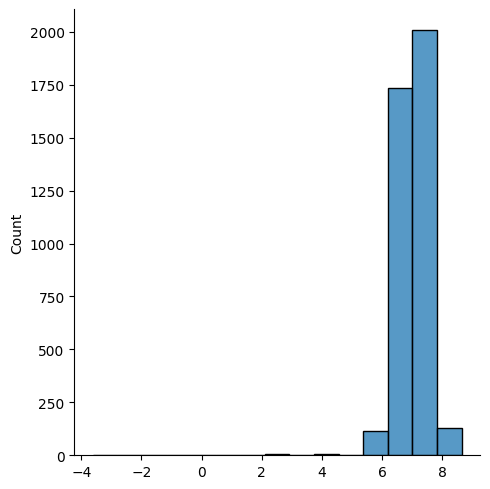

In [85]:
no_outliers = [n for n in df['y_rep.700'].to_numpy() if (-100< n < 100)]
sns.displot(no_outliers, bins=15)
plt.show()

In [86]:
res_df['Prices'].describe(percentiles=[0.25, 0.5, 0.75])

count     130.000000
mean     1105.599995
std       135.579110
min       615.048808
25%      1049.043220
50%      1106.977613
75%      1184.024796
max      1459.675400
Name: Prices, dtype: float64

In [87]:
import matplotlib.pyplot as plt
def plot_ts(dataframe, col):
    # Plot the time series data
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe['Datetime'], dataframe[col], linestyle='-', color='black', linewidth = 0.5)
    # plt.axvline(x=pd.to_datetime('2023-08-24'), color='red', linestyle='--', label='Vertical Line')
    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

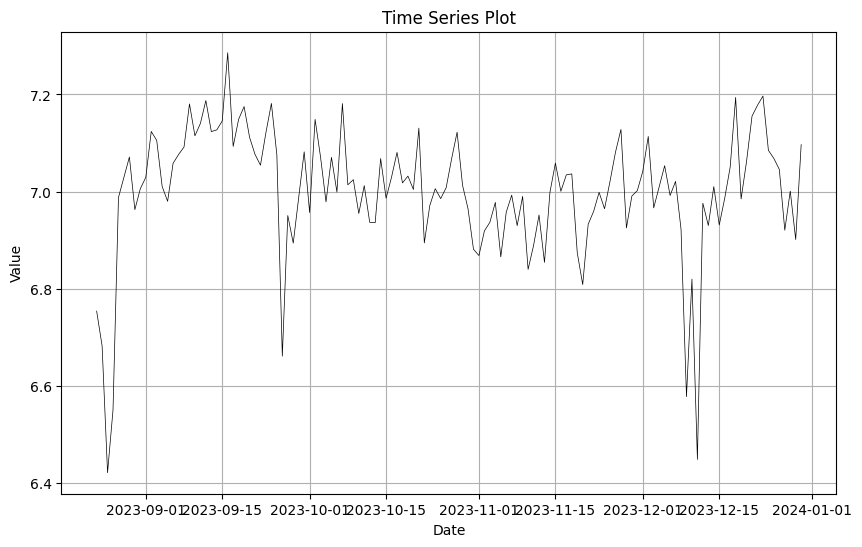

In [88]:
plot_ts(res_df, 'LogPrices')

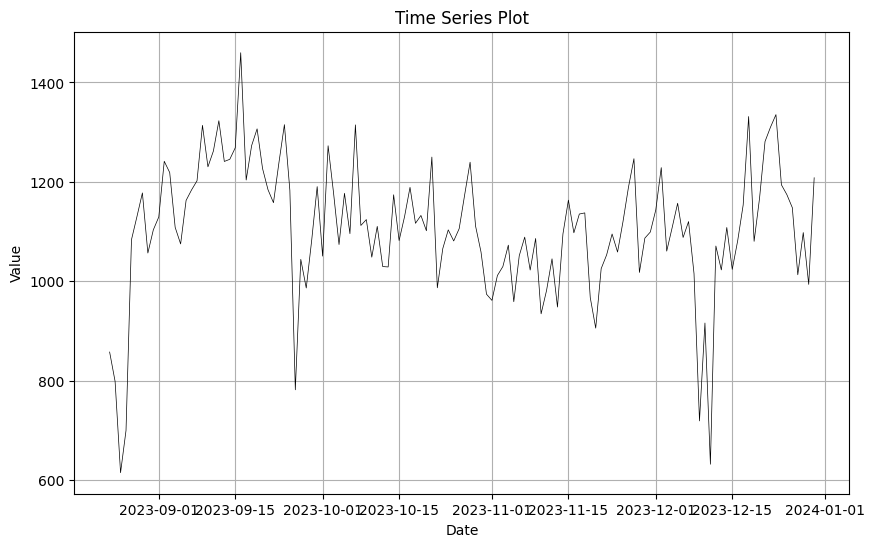

In [89]:
plot_ts(res_df, 'Prices')

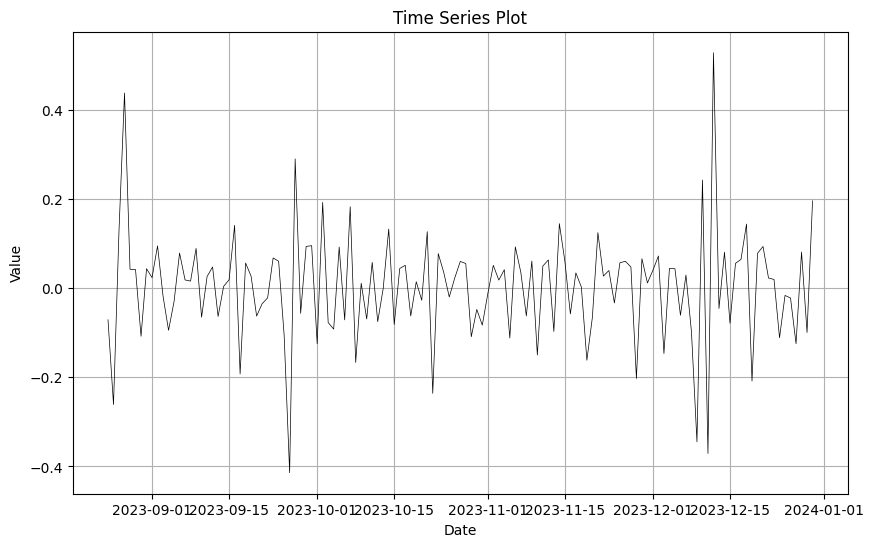

In [90]:
plot_ts(res_df, 'LogDiff')